<a href="https://colab.research.google.com/github/kevintsi/deep_learning_course/blob/main/Atelier_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier Keras Cats VS Dogs

## Environnement matériel et logiciel

In [25]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8739413906852445686
xla_global_id: -1
]


In [19]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Prise en charge des données

### Création d'un jeu d'apprentissage et de validation

In [4]:
data_dir = 'drive/MyDrive/' # chemin d'accès aux données

N_train = 200 #2000
N_val = 80 #800

data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

### Illustration des données

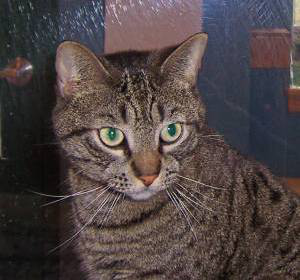

In [5]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

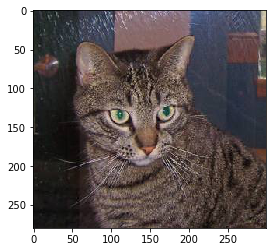

In [6]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

### Pré-traitements

In [7]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

In [8]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [9]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

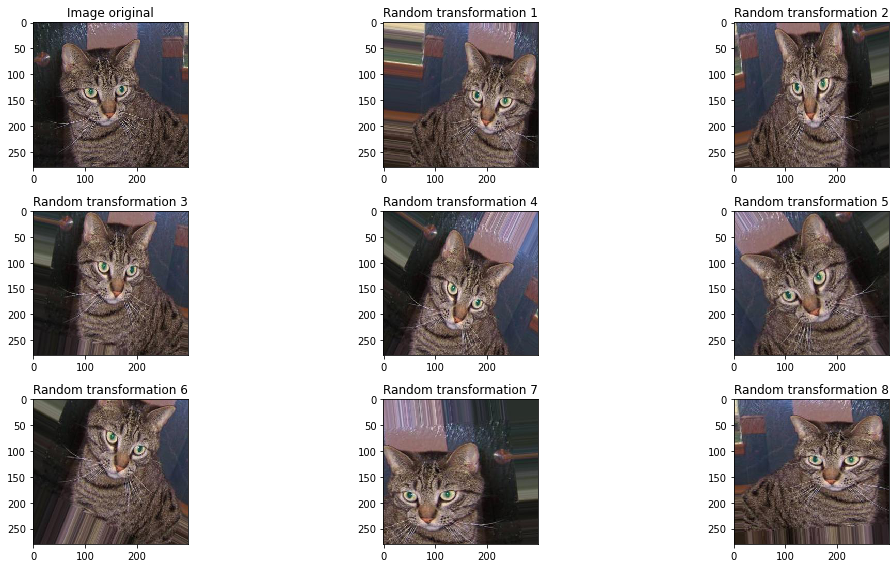

In [14]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Classification d'image à l'aide du Deep Learning

In [20]:
epochs = 10
batch_size=20

### Réseau convolutionnel

#### Génération des données

In [21]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 3 classes.
Found 80 images belonging to 3 classes.


#### Définition du modèle

In [22]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

#### Apprentissage

In [18]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir_sub+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5'%(epochs, batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
10/10 [==============================] - 82s 8s/step - loss: -2077.0662 - accuracy: 0.4550 - val_loss: -14650.6016 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 6s 632ms/step - loss: -67347.6875 - accuracy: 0.5000 - val_loss: -183421.1250 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 6s 623ms/step - loss: -360600.0312 - accuracy: 0.5000 - val_loss: -719988.8125 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 6s 628ms/step - loss: -1166286.3750 - accuracy: 0.5000 - val_loss: -1891027.6250 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 6s 623ms/step - loss: -2728064.0000 - accuracy: 0.5000 - val_loss: -3963604.0000 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 6s 620ms/step - loss: -5277918.5000 - accuracy: 0.5000 - val_loss: -7339974.5000 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 6s 616ms/step - loss: -9

#### Prédiction

In [23]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


4/4 [==============================] - 1s 168ms/step - loss: 0.6329 - accuracy: 0.4750


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


10/10 [==============================] - 2s 184ms/step - loss: 0.6296 - accuracy: 0.4650
Train accuracy: 0.4650000035762787
Validation accuracy: 0.4749999940395355
Time Prediction: 4.37 seconds


### Réseau pré-entrainé : VGG16

#### Extraction de nouvelle caractéristiques (features)

Téléchargement des poids du modèle

In [28]:
model_VGG16_without_top = ka.vgg16.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

58900480/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Création des caractéristiques

In [29]:
features_train_path = data_dir_sub+'/features_train.npy' 
features_validation_path = data_dir_sub+'/features_validation.npy' 

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
            data_dir_sub+"/train",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  
    features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)

    
    generator = datagen.flow_from_directory(
        data_dir_sub+"/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_validation_path, 'wb'), features_validation)
    

Generate Features
Found 200 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


10/10 [==============================] - 39s 4s/step
Found 80 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


4/4 [==============================] - 16s 4s/step


Construction d'un réseaux de neurone classique.

In [30]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                524352    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 524,417
Trainable params: 524,417
Non-trainable params: 0
_________________________________________________________________


Apprentissage

In [31]:
# On créer des vecteurs labels

train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

Epoch 1/10
10/10 [==============================] - 1s 25ms/step - loss: 1.2023 - accuracy: 0.4950 - val_loss: 0.4884 - val_accuracy: 0.7750
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.5490 - accuracy: 0.6900 - val_loss: 0.4753 - val_accuracy: 0.8125
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.4971 - accuracy: 0.7400 - val_loss: 0.3673 - val_accuracy: 0.8875
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3563 - accuracy: 0.8250 - val_loss: 0.2930 - val_accuracy: 0.9000
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3123 - accuracy: 0.8800 - val_loss: 0.3289 - val_accuracy: 0.8125
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3142 - accuracy: 0.8450 - val_loss: 0.3960 - val_accuracy: 0.8125
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2133 - accuracy: 0.9300 - val_loss: 0.2402 - val_accuracy: 0.9250
Epoch 8/10
10/

In [32]:
model_VGG_fcm.save_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

Prédiction

In [33]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

7/7 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9950
Train accuracy: 0.9950000047683716
Validation accuracy: 0.8500000238418579
Time Prediction: 0.29 seconds


### Ajustement fin du réseau VGG16

### Création du modèle

In [35]:
# build the VGG16 network
model_VGG16_without_top = ka.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
print('Model loaded.')

Model loaded.


In [36]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

top_model.load_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))